In [15]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
from numpy.random import choice, randint
import MeCab
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [8]:
positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

In [9]:
class Tokenizer:
    def __init__(self):
        mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
        self.parser = mecab.parse
            

    def tokenize(self, text):
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = " ".join([i[2] for i in l if len(i) >=4]) # has POS.)
        return res

In [12]:
Tokenizer().tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

'認める たい ない もの だ な 。 自分自身 の 若さ故の過ち という もの を 。'

In [13]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char", lang="En"):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        if lang == "Ja":
            t = Tokenizer()
            positive_examples = [t.tokenize(s) for s in positive_examples]
            negative_examples = [t.tokenize(s) for s in negative_examples]
        else:
            positive_examples = [s.strip() for s in positive_examples]
            negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    n_pos = len(positive_examples)
    n_neg = len(negative_examples)
    ratio = n_pos/n_neg
    print("# pos: ", n_pos)
    print("# neg: ", n_neg)
    print("pos/neg:", ratio)
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y, ratio

In [16]:
%%notify
x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level="word", lang="Ja")
#x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level="char", lang="Ja")

# pos:  43179
# neg:  5788
pos/neg: 7.460089841050449


<IPython.core.display.Javascript object>

In [17]:
long_doc = True

In [18]:
len(x_text)

48967

In [19]:
x_text[0]

'crocs の 偽物 サンダル は 今や どこ に でも 売る て いる ます が 、 昔 買う た もの は けっこう 丈夫 に 出来る て いる て 長い 履ける た の です が 、 最近 の 物 は 底 が 柔らかい 、 石 など を 踏む で しまう と 足 の 裏 が 痛い し 、 すぐ に 底 が すり減る て 履ける ない なる て しまう 。 安物 買い を やめる て 、 正規 の crocs 公式 品 を 買う て みる ます た が 、 やはり 底 が 頑丈 で 履く 心地 が いい 。 底 が 柔らかい て ふにゃふにゃ の クッション性 を 求める て いる 人 に は 、 固い て 満足 出来る ない かも しれる ます ん が 、 散歩 や 買い物 に 行く 時 など サンダル を 普段 履く する 自分 にとって は この くらい しっかり する て いる ない と 履ける た もの だ は ない です 。 満足 の いく 買い物 が 出来る ます た 。'

In [20]:
length_list = np.array([len(r)for r in x_text])

In [21]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,451
1,161
2,130
3,273
4,363


In [22]:
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

,length
count,48967.000000
mean,200.733474
std,277.468464
min,4.000000
50%,137.000000
75%,229.000000
80%,260.000000
90%,371.000000
95%,528.700000
max,13936.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c251492b0>]],
      dtype=object)

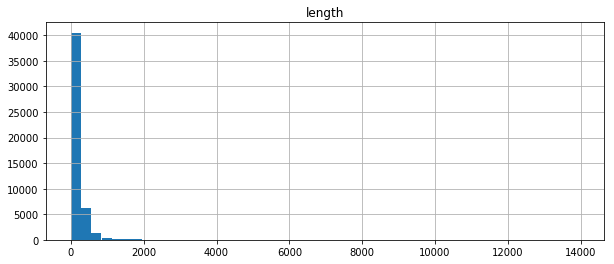

In [23]:
df.hist(bins=50,figsize=(10,4))

In [24]:
max_length = int(df.quantile(0.95)["length"]) #1000
if long_doc:
    print("cut length to ", max_length)
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

cut length to  528


,length
count,48967.000000
mean,177.694284
std,128.380369
min,4.000000
50%,137.000000
75%,229.000000
80%,260.000000
90%,371.000000
95%,528.000000
max,528.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c249cc4e0>]],
      dtype=object)

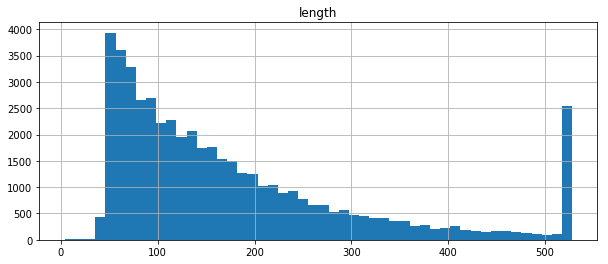

In [25]:
df.hist(bins=50,figsize=(10,4))

In [26]:
vocab_processor = preprocessing.VocabularyProcessor(max_length)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [27]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


<IPython.core.display.Javascript object>

In [28]:
test_percentage = 0.1

In [29]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 46594
Train/Test split: 44071/4896


<IPython.core.display.Javascript object>

In [30]:
print(x_train.shape)

(44071, 528)


In [31]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [32]:
class RNN:
    def __init__(self, sequence_length, num_classes, vocab_size, embedding_size,
                 cell_type, hidden_size, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_text = tf.placeholder(tf.int32, shape=[None, sequence_length], name='input_text')
        self.input_y = tf.placeholder(tf.float32, shape=[None, num_classes], name='input_y')
        self.dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')

        l2_loss = tf.constant(0.0)
        text_length = self._length(self.input_text)

        with tf.device('/cpu:0'), tf.name_scope("text-embedding"):
            self.W_text = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W_text")
            self.embedded_chars = tf.nn.embedding_lookup(self.W_text, self.input_text)


        with tf.name_scope("rnn"):
            cell = self._get_cell(hidden_size, cell_type)
            cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=self.dropout_keep_prob)
            all_outputs, _ = tf.nn.dynamic_rnn(cell=cell, inputs=self.embedded_chars, sequence_length=text_length, dtype=tf.float32)
            self.h_outputs = self.last_relevant(all_outputs, text_length)


        with tf.name_scope("output"):
            W = tf.get_variable("W", shape=[hidden_size, num_classes], initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.logits = tf.nn.xw_plus_b(self.h_outputs, W, b, name="logits")
            self.predictions = tf.argmax(self.logits, 1, name="predictions")


        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, axis=1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name="accuracy")

    @staticmethod
    def _get_cell(hidden_size, cell_type):
        if cell_type == "vanilla":
            return tf.nn.rnn_cell.BasicRNNCell(hidden_size)
        elif cell_type == "lstm":
            return tf.nn.rnn_cell.BasicLSTMCell(hidden_size)
        elif cell_type == "gru":
            return tf.nn.rnn_cell.GRUCell(hidden_size)
        else:
            print("ERROR: '" + cell_type + "' is a wrong cell type !!!")
            return None

    # Length of the sequence data
    @staticmethod
    def _length(seq):
        relevant = tf.sign(tf.abs(seq))
        length = tf.reduce_sum(relevant, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        return length

    # Extract the output of last cell of each sequence
    # Ex) The movie is good -> length = 4
    #     output = [ [1.314, -3.32, ..., 0.98]
    #                [0.287, -0.50, ..., 1.55]
    #                [2.194, -2.12, ..., 0.63]
    #                [1.938, -1.88, ..., 1.31]
    #                [  0.0,   0.0, ...,  0.0]
    #                ...
    #                [  0.0,   0.0, ...,  0.0] ]
    #     The output we need is 4th output of cell, so extract it.
    @staticmethod
    def last_relevant(seq, length):
        batch_size = tf.shape(seq)[0]
        max_length = int(seq.get_shape()[1])
        input_size = int(seq.get_shape()[2])
        index = tf.range(0, batch_size) * max_length + (length - 1)
        flat = tf.reshape(seq, [-1, input_size])
        return tf.gather(flat, index)

In [38]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [36]:
cell_type="vanilla"
word2vec=None
embedding_dim=300
hidden_size=128
dropout_keep_prob=0.5
l2_reg_lambda=3.0

In [41]:
batch_size = 64
display_every=10
num_epochs = 200            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True


#timestamp = str(int(time.time()))
#timestamp = "1525609926"
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
#out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp, prefix))
out_dir = os.path.join(os.path.curdir, "runs", time_path, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/2018_07_11_21_08_34/



In [ ]:
with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
            allow_soft_placement=allow_soft_placement,
            log_device_placement=log_device_placement)
        
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            rnn = RNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=vocab_size,
                embedding_size=embedding_dim,
                cell_type=cell_type,
                hidden_size=hidden_size,
                l2_reg_lambda=l2_reg_lambda
            )


            global_step = tf.Variable(0, name="global_step", trainable=False)
            train_op = tf.train.AdamOptimizer(learning_rate).minimize(rnn.loss, global_step=global_step)


            loss_summary = tf.summary.scalar("loss", rnn.loss)
            acc_summary = tf.summary.scalar("accuracy", rnn.accuracy)

            train_summary_op = tf.summary.merge([loss_summary, acc_summary])
            train_summary_dir = os.path.join(out_dir, "summaries", "train")
            train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

            test_summary_op = tf.summary.merge([loss_summary, acc_summary])
            test_summary_dir = os.path.join(out_dir, "summaries", "test")
            test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

            sess.run(tf.global_variables_initializer())

            # Pre-trained word2vec
            if word2vec:
                # initial matrix with random uniform
                initW = np.random.uniform(-0.25, 0.25, (len(text_vocab_processor.vocabulary_), embedding_dim))
                # load any vectors from the word2vec
                print("Load word2vec file {0}".format(word2vec))
                with open(word2vec, "rb") as f:
                    header = f.readline()
                    vocab_size, layer1_size = map(int, header.split())
                    binary_len = np.dtype('float32').itemsize * layer1_size
                    for line in range(vocab_size):
                        word = []
                        while True:
                            ch = f.read(1).decode('latin-1')
                            if ch == ' ':
                                word = ''.join(word)
                                break
                            if ch != '\n':
                                word.append(ch)
                        idx = text_vocab_processor.vocabulary_.get(word)
                        if idx != 0:
                            initW[idx] = np.fromstring(f.read(binary_len), dtype='float32')
                        else:
                            f.read(binary_len)
                sess.run(rnn.W_text.assign(initW))
                print("Success to load pre-trained word2vec model!\n")


            batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)

            for batch in batches:
                x_batch, y_batch = zip(*batch)
                feed_dict = {
                    rnn.input_text: x_batch,
                    rnn.input_y: y_batch,
                    rnn.dropout_keep_prob: dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, rnn.loss, rnn.accuracy], feed_dict)
                train_summary_writer.add_summary(summaries, step)

                if step % display_every == 0:
                    time_str = datetime.datetime.now().isoformat()
                    print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))

                if step % evaluate_every == 0:
                    print("\nEvaluation:")
                    feed_dict_test = {
                        rnn.input_text: x_test,
                        rnn.input_y: y_test,
                        rnn.dropout_keep_prob: 1.0
                    }
                    summaries_test, loss, accuracy = sess.run([test_summary_op, rnn.loss, rnn.accuracy], feed_dict_test)
                    test_summary_writer.add_summary(summaries_test, step)

                    time_str = datetime.datetime.now().isoformat()
                    print("{}: step {}, loss {:g}, acc {:g}\n".format(time_str, step, loss, accuracy))

                if step % checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=step)
                    print("Saved model checkpoint to {}\n".format(path))

/Users/tdual/anaconda2/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


num of epochs:  200
num of batches:  689
num of step:  137800
2018-07-11T21:08:41.042047: step 10, loss 5.61865, acc 0.828125
2018-07-11T21:08:44.879057: step 20, loss 4.90508, acc 0.84375

Evaluation:
2018-07-11T21:09:05.526318: step 20, loss 4.86884, acc 0.847631

2018-07-11T21:09:10.038187: step 30, loss 4.36942, acc 0.8125
2018-07-11T21:09:14.276855: step 40, loss 3.84761, acc 0.78125

Evaluation:
2018-07-11T21:09:26.822194: step 40, loss 3.68801, acc 0.86009

2018-07-11T21:09:30.958727: step 50, loss 3.18964, acc 0.90625
2018-07-11T21:09:35.118260: step 60, loss 2.938, acc 0.828125

Evaluation:
2018-07-11T21:09:47.604426: step 60, loss 2.77817, acc 0.870507

2018-07-11T21:09:51.839616: step 70, loss 2.25718, acc 0.953125
2018-07-11T21:09:55.927078: step 80, loss 2.05108, acc 0.90625

Evaluation:
2018-07-11T21:10:16.062352: step 80, loss 2.10435, acc 0.875

2018-07-11T21:10:20.206205: step 90, loss 1.89282, acc 0.875
2018-07-11T21:10:24.237110: step 100, loss 1.55102, acc 0.921875


2018-07-11T21:21:34.685134: step 720, loss 0.252979, acc 0.9375

Evaluation:
2018-07-11T21:21:47.827881: step 720, loss 0.332816, acc 0.899101

2018-07-11T21:21:52.148409: step 730, loss 0.391459, acc 0.859375
2018-07-11T21:21:56.458050: step 740, loss 0.387971, acc 0.875

Evaluation:
2018-07-11T21:22:09.837454: step 740, loss 0.336011, acc 0.894812

2018-07-11T21:22:14.195202: step 750, loss 0.197811, acc 0.96875
2018-07-11T21:22:18.461633: step 760, loss 0.245561, acc 0.953125

Evaluation:
2018-07-11T21:22:31.525868: step 760, loss 0.326957, acc 0.902369

2018-07-11T21:22:35.694958: step 770, loss 0.319789, acc 0.921875
2018-07-11T21:22:39.968278: step 780, loss 0.377672, acc 0.875

Evaluation:
2018-07-11T21:22:53.039453: step 780, loss 0.343006, acc 0.887459

2018-07-11T21:22:57.287526: step 790, loss 0.321594, acc 0.90625
2018-07-11T21:23:01.590946: step 800, loss 0.230331, acc 0.9375

Evaluation:
2018-07-11T21:23:15.357311: step 800, loss 0.335551, acc 0.890727

Saved model checkp

2018-07-11T21:34:34.902857: step 1420, loss 0.338989, acc 0.900123

2018-07-11T21:34:39.362709: step 1430, loss 0.251125, acc 0.9375
2018-07-11T21:34:43.682194: step 1440, loss 0.266492, acc 0.921875

Evaluation:
2018-07-11T21:34:56.637227: step 1440, loss 0.32067, acc 0.899306

2018-07-11T21:35:00.636683: step 1450, loss 0.215066, acc 0.96875
2018-07-11T21:35:04.552417: step 1460, loss 0.365276, acc 0.890625

Evaluation:
2018-07-11T21:35:16.039338: step 1460, loss 0.312756, acc 0.907884

2018-07-11T21:35:19.966319: step 1470, loss 0.347193, acc 0.90625
2018-07-11T21:35:23.863645: step 1480, loss 0.369113, acc 0.875

Evaluation:
2018-07-11T21:35:35.205581: step 1480, loss 0.309562, acc 0.907884

2018-07-11T21:35:39.158302: step 1490, loss 0.298814, acc 0.921875
2018-07-11T21:35:43.087779: step 1500, loss 0.341663, acc 0.890625

Evaluation:
2018-07-11T21:35:56.161954: step 1500, loss 0.308275, acc 0.903391

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_11_

2018-07-11T21:46:12.197617: step 2120, loss 0.314037, acc 0.911152

2018-07-11T21:46:16.101910: step 2130, loss 0.295989, acc 0.921875
2018-07-11T21:46:19.903348: step 2140, loss 0.346511, acc 0.90625

Evaluation:
2018-07-11T21:46:31.997860: step 2140, loss 0.305904, acc 0.908497

2018-07-11T21:46:36.001922: step 2150, loss 0.256937, acc 0.921875
2018-07-11T21:46:40.306099: step 2160, loss 0.227227, acc 0.9375

Evaluation:
2018-07-11T21:46:52.656323: step 2160, loss 0.304317, acc 0.910335

2018-07-11T21:46:56.585796: step 2170, loss 0.307945, acc 0.90625
2018-07-11T21:47:00.542489: step 2180, loss 0.30267, acc 0.90625

Evaluation:
2018-07-11T21:47:12.580855: step 2180, loss 0.29727, acc 0.91442

2018-07-11T21:47:16.401615: step 2190, loss 0.227013, acc 0.953125
2018-07-11T21:47:20.333252: step 2200, loss 0.195247, acc 0.984375

Evaluation:
2018-07-11T21:47:36.756834: step 2200, loss 0.299007, acc 0.912173

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_11_

2018-07-11T21:58:24.962896: step 2820, loss 0.300163, acc 0.911969

2018-07-11T21:58:29.285745: step 2830, loss 0.415016, acc 0.875
2018-07-11T21:58:33.456079: step 2840, loss 0.226998, acc 0.953125

Evaluation:
2018-07-11T21:58:45.878216: step 2840, loss 0.319599, acc 0.89808

2018-07-11T21:58:50.073977: step 2850, loss 0.233642, acc 0.9375
2018-07-11T21:58:54.290835: step 2860, loss 0.262441, acc 0.953125

Evaluation:
2018-07-11T21:59:06.713378: step 2860, loss 0.320927, acc 0.911969

2018-07-11T21:59:10.914876: step 2870, loss 0.264337, acc 0.9375
2018-07-11T21:59:15.753074: step 2880, loss 0.284139, acc 0.921875

Evaluation:
2018-07-11T21:59:28.070337: step 2880, loss 0.29995, acc 0.91299

2018-07-11T21:59:32.119868: step 2890, loss 0.200295, acc 0.96875
2018-07-11T21:59:36.148749: step 2900, loss 0.226676, acc 0.953125

Evaluation:
2018-07-11T21:59:47.853360: step 2900, loss 0.297574, acc 0.913603

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_11_21_

2018-07-11T22:11:29.350158: step 3520, loss 0.315898, acc 0.90482

2018-07-11T22:11:33.759203: step 3530, loss 0.278142, acc 0.9375
2018-07-11T22:11:37.857080: step 3540, loss 0.224364, acc 0.96875

Evaluation:
2018-07-11T22:11:50.777784: step 3540, loss 0.306062, acc 0.908292

2018-07-11T22:11:54.818397: step 3550, loss 0.178145, acc 0.953125
2018-07-11T22:11:59.164803: step 3560, loss 0.187559, acc 0.96875

Evaluation:
2018-07-11T22:12:12.223315: step 3560, loss 0.319358, acc 0.89951

2018-07-11T22:12:16.696583: step 3570, loss 0.277701, acc 0.921875
2018-07-11T22:12:20.973429: step 3580, loss 0.365835, acc 0.890625

Evaluation:
2018-07-11T22:12:34.218804: step 3580, loss 0.321042, acc 0.894404

2018-07-11T22:12:38.266064: step 3590, loss 0.313977, acc 0.890625
2018-07-11T22:12:42.318620: step 3600, loss 0.231202, acc 0.953125

Evaluation:
2018-07-11T22:12:55.567745: step 3600, loss 0.31232, acc 0.906046

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/2018_07_11